In [28]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [29]:
import sys
sys.path.append('clustering/')

from utils import *

In [ ]:
import pickle
from sklearn.cluster import KMeans
d, w = 100, 10
K = 26
method = "kmeans"

start_year, end_year = 2010, 2021

with open(os.path.join(get_data_dir(), "2010s", "vectors.pkl"), 'rb') as f:
        vectors = pickle.load(f)
kmeans = KMeans(n_clusters=K, random_state=42).fit(vectors)

with open(os.path.join(get_data_dir(), "2010s", f'cluster_labels_{method}.pkl'), 'wb') as f:
        pickle.dump(kmeans.labels_,f)
with open(os.path.join(get_data_dir(), "2010s", f'cluster_centers_{method}.pkl'), 'wb') as f:
        pickle.dump(kmeans.cluster_centers_, f)

/home/lyuzhuoqi/miniconda3/envs/p2v/lib/python3.11/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.26.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


data_dir:  /home/lyuzhuoqi/projects/clustering/data
data_dir:  /home/lyuzhuoqi/projects/clustering/data
data_dir:  /home/lyuzhuoqi/projects/clustering/data


Fitting model for k=10
Fitting model for k=20
Fitting model for k=30
Fitting model for k=40
Fitting model for k=50
Fitting model for k=60
Fitting model for k=70
Fitting model for k=80
Fitting model for k=90
Fitting model for k=100
Fitting model for k=110
Fitting model for k=120
Fitting model for k=130
Fitting model for k=140
Fitting model for k=150


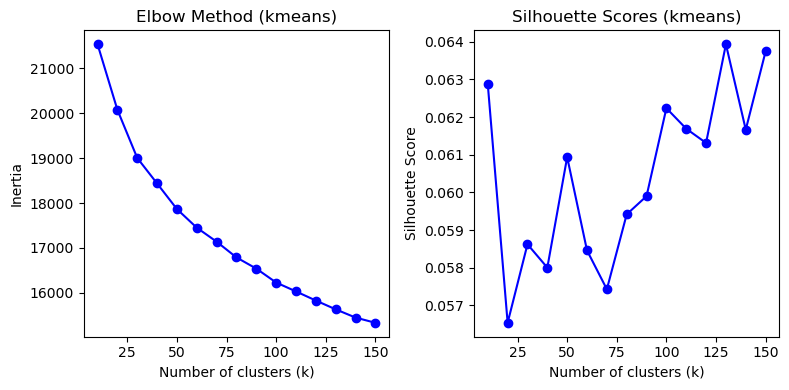

In [259]:
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# Define the range of k values to test
k_values = range(10, 151, 10)

# Initialize lists to store the results
inertia = []
silhouette_scores = []

# Loop over the range of k values
for k in k_values:
    print(f'Fitting model for k={k}')
    kmeans = KMeans(n_clusters=k, random_state=42).fit(vectors)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(vectors, kmeans.labels_))

# Plot the elbow method
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(k_values, inertia, 'bo-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title(f'Elbow Method ({method})')

# Plot the silhouette scores
plt.subplot(1, 2, 2)
plt.plot(k_values, silhouette_scores, 'bo-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.title(f'Silhouette Scores ({method})')

plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd

cluster_df = pd.read_parquet(os.path.join(get_data_dir(), "2010s", "cluster_df.parquet"))
cluster_df

data_dir:  /home/lyuzhuoqi/projects/clustering/data


,Scopus_label,movMF_label,movMF_distance,x_val,y_val,kmeans_label,closest_center_distance
VID,,,,,,,
202381698,Multidisciplinary,22,0.445886,-67.928200,15.572327,17,0.628846
137773608,Multidisciplinary,22,0.590942,-68.405334,-55.633186,17,0.735654
125754415,Multidisciplinary,22,0.574571,-68.448853,-55.613579,17,0.705024
3880285,Multidisciplinary,23,0.618842,-68.407288,-55.634430,8,0.724859
111155417,Chemistry,23,0.220853,-54.506985,-61.217068,11,0.495787
...,...,...,...,...,...,...,...
2764485818,Medicine,21,0.268070,-28.969574,34.819569,18,0.542531
83454320,Arts and Humanities,25,0.034777,78.609909,31.736822,13,0.251599
16507453,Arts and Humanities,6,0.113656,89.206772,17.625090,13,0.307089


In [73]:
# 生成一个字典，key为kmeans_label，value为该kmeans_label中出现次数最多的Scopus_label
label_counts = cluster_df.groupby(['kmeans_label', 'Scopus_label']).size().unstack(fill_value=0)
kmeans2Scopus = label_counts.idxmax(axis=1).to_dict()

kmeans2Scopus

{0: 'Social Sciences',
 1: 'Social Sciences',
 2: 'Computer Science',
 3: 'Medicine',
 4: 'Medicine',
 5: 'Engineering',
 6: 'Physics and Astronomy',
 7: 'Medicine',
 8: 'Agricultural and Biological Sciences',
 9: 'Psychology',
 10: 'Engineering',
 11: 'Chemistry',
 12: 'Earth and Planetary Sciences',
 13: 'Arts and Humanities',
 14: 'Engineering',
 15: 'Mathematics',
 16: 'Veterinary',
 17: 'Biochemistry, Genetics and Molecular Biology',
 18: 'Medicine',
 19: 'Social Sciences',
 20: 'Medicine',
 21: 'Agricultural and Biological Sciences',
 22: 'Medicine',
 23: 'Social Sciences',
 24: 'Business, Management and Accounting',
 25: 'Social Sciences'}

In [ ]:
import pandas as pd
import os
import plotly.graph_objects as go
from matplotlib.colors import LinearSegmentedColormap, to_rgba

# 读取数据
cluster_df = pd.read_parquet(os.path.join(get_data_dir(), "2010s", "cluster_df.parquet"))

# 获取唯一标签
scopus_labels = cluster_df['Scopus_label'].unique()
kmeans_labels = cluster_df['kmeans_label'].unique()

# 生成颜色
Scopus_colors = [disc2color[scopus_label] for scopus_label in scopus_labels]
kmeans_colors = [disc2color[kmeans2Scopus[kmeans_label]] for kmeans_label in kmeans_labels]

# 创建标签映射
label_map = {label: i for i, label in enumerate(scopus_labels)}
label_map.update({label: i + len(scopus_labels) for i, label in enumerate(kmeans_labels)})

# 创建桑基图数据
cluster_group = cluster_df.groupby(['Scopus_label', 'kmeans_label']).size().reset_index(name='count')
source = cluster_group['Scopus_label'].map(label_map).tolist()
target = cluster_group['kmeans_label'].map(label_map).tolist()
value = cluster_group['count'].tolist()

# 创建渐变颜色，并降低不透明度
link_colors = []
alpha = 0.5  # 设置透明度，范围 [0, 1]
for i, row in cluster_group.iterrows():
    source_color = to_rgba(disc2color[row['Scopus_label']], alpha=1.0)
    target_color = to_rgba(disc2color[kmeans2Scopus[row['kmeans_label']]], alpha=1.0)
    cmap = LinearSegmentedColormap.from_list("source_target", [source_color, target_color])
    mid_color = cmap(0.5)  # 在中间点取颜色
    link_colors.append(f'rgba({mid_color[0]*255},{mid_color[1]*255},{mid_color[2]*255},{alpha})')  # 设置 alpha

# 创建桑基图
fig = go.Figure(data=[go.Sankey(
    node=dict(
        pad=10,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=list(scopus_labels) + list(kmeans_labels),
        color=Scopus_colors + kmeans_colors
    ),
    link=dict(
        source=source,
        target=target,
        value=value,
        color=link_colors  # 设置渐变颜色
    )
)])

# 更新布局
fig.update_layout(title_text="Scopus_label to kmeans_label", font_size=10,
                  autosize=False, width=800, height=800)

# 显示图表
fig.show()

data_dir:  /home/lyuzhuoqi/projects/clustering/data


In [170]:
cluster_df.value_counts('kmeans_label')

kmeans_label
13    1277
17    1277
7     1272
24    1242
9     1168
14     983
23     969
20     962
11     933
4      838
8      811
25     808
0      773
15     765
21     732
12     723
1      649
18     569
22     562
5      547
6      545
3      467
2      430
19     383
16     292
10      61
Name: count, dtype: int64

In [224]:
# 读取数据
cluster_df = pd.read_parquet(os.path.join(get_data_dir(), "2010s", "cluster_df.parquet"))

min_threshold = 200
# min_threshold = 0

# 统计流量信息，按 Scopus_label 和 kmeans_label 分组计数
flow_data = (
    cluster_df.groupby(["Scopus_label", "kmeans_label"])
    .size()
    .reset_index(name="flow")
    .apply(lambda row: [row["Scopus_label"], str(row["kmeans_label"]), row["flow"]], axis=1)
    .tolist()
)
filtered_flow_data = [entry for entry in flow_data if entry[2] > min_threshold]

filtered_flow_data

data_dir:  /home/lyuzhuoqi/projects/clustering/data


[['Agricultural and Biological Sciences', '8', 616],
 ['Agricultural and Biological Sciences', '21', 526],
 ['Arts and Humanities', '13', 1107],
 ['Arts and Humanities', '23', 202],
 ['Biochemistry, Genetics and Molecular Biology', '17', 538],
 ['Business, Management and Accounting', '24', 591],
 ['Chemistry', '11', 332],
 ['Computer Science', '2', 291],
 ['Computer Science', '5', 228],
 ['Earth and Planetary Sciences', '12', 447],
 ['Economics, Econometrics and Finance', '24', 402],
 ['Engineering', '5', 251],
 ['Engineering', '14', 561],
 ['Materials Science', '11', 232],
 ['Mathematics', '15', 638],
 ['Medicine', '3', 313],
 ['Medicine', '4', 816],
 ['Medicine', '7', 1199],
 ['Medicine', '9', 377],
 ['Medicine', '17', 280],
 ['Medicine', '18', 437],
 ['Medicine', '20', 625],
 ['Medicine', '22', 401],
 ['Physics and Astronomy', '6', 317],
 ['Psychology', '9', 467],
 ['Social Sciences', '0', 629],
 ['Social Sciences', '1', 293],
 ['Social Sciences', '19', 303],
 ['Social Sciences', '2

In [225]:
node_appearance_order = []
for entry in filtered_flow_data:
    if entry[0] not in node_appearance_order:
        node_appearance_order.append(entry[0])
    if int(entry[1]) not in node_appearance_order:
        node_appearance_order.append(int(entry[1]))
node_appearance_order

['Agricultural and Biological Sciences',
 8,
 21,
 'Arts and Humanities',
 13,
 23,
 'Biochemistry, Genetics and Molecular Biology',
 17,
 'Business, Management and Accounting',
 24,
 'Chemistry',
 11,
 'Computer Science',
 2,
 5,
 'Earth and Planetary Sciences',
 12,
 'Economics, Econometrics and Finance',
 'Engineering',
 14,
 'Materials Science',
 'Mathematics',
 15,
 'Medicine',
 3,
 4,
 7,
 9,
 18,
 20,
 22,
 'Physics and Astronomy',
 6,
 'Psychology',
 'Social Sciences',
 0,
 1,
 19,
 25]

In [226]:
node_color = node_appearance_order.copy()
for i, label in enumerate(node_appearance_order):
    if type(label) == str:
        node_color[i] = disc2color[label]
    else:
        node_color[i] = disc2color[kmeans2Scopus[label]]
node_color

['#000099',
 '#000099',
 '#000099',
 '#375623',
 '#375623',
 '#66FF66',
 '#336699',
 '#336699',
 '#187402',
 '#187402',
 '#9A0000',
 '#9A0000',
 '#FF5C29',
 '#FF5C29',
 '#D20000',
 '#FE0000',
 '#FE0000',
 '#8FA329',
 '#D20000',
 '#D20000',
 '#FC9320',
 '#FBFF57',
 '#FBFF57',
 '#7030A0',
 '#7030A0',
 '#7030A0',
 '#7030A0',
 '#92D050',
 '#7030A0',
 '#7030A0',
 '#7030A0',
 '#FFCC00',
 '#FFCC00',
 '#92D050',
 '#66FF66',
 '#66FF66',
 '#66FF66',
 '#66FF66',
 '#66FF66']

In [227]:
import pandas as pd
from pandarallel import pandarallel
pandarallel.initialize(progress_bar=True)
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer

# 自定义词映射
word_mapping = {'mechanics': 'mechanic',
                'mechanical': 'mechanic',
                'electrical': 'electric',
                'electronics': 'electric',
                'financial': 'finance',
                'political': 'politics',
                'historical': 'history',
                'computer': 'computing',
                'intelligent': 'intelligence',
                'agricultural': 'agriculture',
                'educational': 'education',
                'dental': 'dentistry',
                'archaeological': 'archaeology',
                'mathematical': 'mathematics',
                'mathematica': 'mathematics',
                'matematico': 'mathematics',
                'mathematicae': 'mathematics',
                'economic': 'economics',
                'chemical': 'chemistry',
                'geophysical': 'geophysics',
                'botanical': 'botany',
                'physical': 'physics',
                'entomological': 'entomology', 
                'entomologist': 'entomology',
                'biological': 'biology',
                'geographical': 'geography',
                'geological': 'geology',
                'geographer': 'geography',
                'cells': 'cell',
                'policy': 'politics',
                'psychological': 'psychology',
                'linguistical': 'linguistics',
                'linguistica': 'linguistics',
                'medical': 'medicine',
}
# 读取数据
cluster_df = pd.read_parquet(os.path.join(get_data_dir(), "2010s", "cluster_df.parquet"))
cluster_df = cluster_df.merge(pd.read_parquet(os.path.join(get_data_dir(), "MAG_venue.parquet")), left_index=True, right_index=True)

# 定义预处理函数，进行自定义词映射
def preprocess_text(text):
    words = text.lower().split()  # 将文本小写并按空格分词
    mapped_words = [word_mapping[word] if word in word_mapping else word for word in words]
    filtered_words = [word for word in mapped_words]
    return ' '.join(filtered_words)

# 按 cluster_label 分组，将 OriginalVenue 文本合并为一个文档，并进行预处理
cluster_docs = (
    cluster_df.groupby('kmeans_label').parallel_apply(lambda x: preprocess_text(' '.join(x.OriginalVenue))).tolist()
)

INFO: Pandarallel will run on 10 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
data_dir:  /home/lyuzhuoqi/projects/clustering/data
data_dir:  /home/lyuzhuoqi/projects/clustering/data


In [228]:
# 自定义停用词
custom_stop_words = ['results', 'model', 'based', 'data', 'proposed', 'study', 'paper', 'results', 
                     'system', 'patients', 'using', 'method', 'health', 'two', 'article', 'la', 'que', 'en',
                     'el', 'et', 'un', 'one', 'also', 'high', 'properties', 'methods', 'among', 'new',
                     'sp', 'use', 'group', 'used', 'process', 'kg', 'abstract', 'different', 'time',
                     'treatment', 'analysis', 'different', 'performance', 'le', 'los', 'se', 'les',
                     'mm', 'may', 'de', 'del', 'des', 'nov', 'found', 'research', 'showed', 'las',
                     'development', 'years', 'da', 'studies', 'first', 'findings', 'di', 'however', 'three',
                     'associated', 'relationship', 'design', 'em', 'approach', 'risk', 'patient', 'care',
                     '95', 'age', 'ci', 'compared', '10', 'background', 'conclusions', 'significant',
                     'higher', 'vs', 'mortality', 'therapy', 'increased', 'significantly', '19', 'children',
                     'find', 'show', 'problem', 'mathrm', 'included', 'mean', 'systems', '12', 'effects',
                     'participants', 'related', 'cases', 'disease', 'levels', 'outcomes', 'non', 'total',
                     'factors', 'conclusion', 'nm', 'ra', 'year', 'dr', 'journal', 'review', 'international',
                     'science', 'chinese', 'university', 'transactions'
                     ]

# 计算 TF-IDF
top_words_vectorizer = TfidfVectorizer(stop_words=stopwords.words('english')+custom_stop_words)
tfidf_matrix = top_words_vectorizer.fit_transform(cluster_docs)

In [229]:
top_n = 5  # 每个聚类提取前 n 个关键词
# 获取每个聚类中最重要的关键词
top_words = {}
feature_names = top_words_vectorizer.get_feature_names_out()

# 确保 cluster_label 的顺序与 cluster_docs 一致
cluster_labels = sorted(cluster_df['kmeans_label'].unique())

for j, cluster_label in enumerate(cluster_labels):
    tfidf_scores = tfidf_matrix[j].toarray().flatten()
    top_indices = tfidf_scores.argsort()[-top_n:][::-1]  # 获取前 n 个关键词的索引
    top_words[cluster_label] = [feature_names[idx] for idx in top_indices]

top_words

{0: ['law', 'politics', 'economics', 'european', 'public'],
 1: ['geography', 'environmental', 'economics', 'politics', 'planning'],
 2: ['computing', 'information', 'acm', 'ieee', 'software'],
 3: ['dentistry', 'oral', 'surgery', 'ophthalmology', 'dermatology'],
 4: ['oncology', 'cancer', 'surgery', 'clinical', 'gastroenterology'],
 5: ['ieee', 'electric', 'engineering', 'computing', 'intelligence'],
 6: ['physics', 'ieee', 'electric', 'materials', 'optics'],
 7: ['medicine', 'clinical', 'cardiovascular', 'cardiology', 'heart'],
 8: ['ecology', 'entomology', 'biology', 'zoology', 'conservation'],
 9: ['psychology', 'psychiatry', 'mental', 'social', 'child'],
 10: ['technology', 'engineering', 'information', 'optics', 'laser'],
 11: ['chemistry', 'materials', 'polymer', 'engineering', 'catalysis'],
 12: ['geology', 'earth', 'geophysics', 'water', 'engineering'],
 13: ['history', 'archaeology', 'literature', 'philosophy', 'historia'],
 14: ['engineering', 'mechanic', 'materials', 'techn

In [230]:
# 读取数据
cluster_df = pd.read_parquet(os.path.join(get_data_dir(), "2010s", "cluster_df.parquet"))

# 统计流量信息，按 Scopus_label 和 kmeans_label 分组计数
flow_data = (
    cluster_df.groupby(["Scopus_label", "kmeans_label"])
    .size()
    .reset_index(name="flow")
    .apply(lambda row: [row["Scopus_label"], str(row["kmeans_label"]), row["flow"]], axis=1)
    .tolist()
)

filtered_flow_data = [entry for entry in flow_data if entry[2] > min_threshold]
for entry in filtered_flow_data:
    entry[1] = ','.join(top_words[int(entry[1])])

data_dir:  /home/lyuzhuoqi/projects/clustering/data


In [231]:
filtered_flow_data

[['Agricultural and Biological Sciences',
  'ecology,entomology,biology,zoology,conservation',
  616],
 ['Agricultural and Biological Sciences',
  'plant,food,agriculture,biotechnology,biology',
  526],
 ['Arts and Humanities',
  'history,archaeology,literature,philosophy,historia',
  1107],
 ['Arts and Humanities',
  'social,culture,sociology,communication,anthropology',
  202],
 ['Biochemistry, Genetics and Molecular Biology',
  'cell,biology,molecular,medicine,immunology',
  538],
 ['Business, Management and Accounting',
  'economics,management,business,finance,accounting',
  591],
 ['Chemistry', 'chemistry,materials,polymer,engineering,catalysis', 332],
 ['Computer Science', 'computing,information,acm,ieee,software', 291],
 ['Computer Science', 'ieee,electric,engineering,computing,intelligence', 228],
 ['Earth and Planetary Sciences',
  'geology,earth,geophysics,water,engineering',
  447],
 ['Economics, Econometrics and Finance',
  'economics,management,business,finance,accounting'